# Henry coefficient Calculations

**TODO:** 
- find a better way to code `s_name`

In [1]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall
using LaTeXStrings

using FileIO
using CSV
using DataFrames

┌ Warning: crystals path directory not found
│   path = /home/ng/DTRA/visualizations/simulation_performance_plots/data/crystals
└ @ Xtals /home/ng/.julia/dev/Xtals/src/misc.jl:181
┌ Warning: data path directory not found
│   path = /home/ng/DTRA/visualizations/simulation_performance_plots/data
└ @ Xtals /home/ng/.julia/dev/Xtals/src/misc.jl:181
┌ Warning: forcefields path directory not found
│   path = /home/ng/DTRA/visualizations/simulation_performance_plots/data/forcefields
└ @ Xtals /home/ng/.julia/dev/Xtals/src/misc.jl:181
┌ Warning: grids path directory not found
│   path = /home/ng/DTRA/visualizations/simulation_performance_plots/data/grids
└ @ Xtals /home/ng/.julia/dev/Xtals/src/misc.jl:181
┌ Warning: molecules path directory not found
│   path = /home/ng/DTRA/visualizations/simulation_performance_plots/data/molecules
└ @ Xtals /home/ng/.julia/dev/Xtals/src/misc.jl:181
┌ Warning: crystals path directory not found
│   path = /home/ng/DTRA/visualizations/simulation_performance_plo

In [2]:
@pyimport adjustText
@pyimport seaborn

In [3]:
# PyPlot.matplotlib.style.use("Solarize_Light2")
PyPlot.matplotlib.style.use("ggplot")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [4]:
set_paths(joinpath(pwd(), "../../data"))

In [5]:
PorousMaterials.rc[:paths][:crystals] = joinpath(pwd(), "../../structure_optimization/post-relaxation_cifs")

"/home/ng/DTRA/visualizations/simulation_performance_plots/../../structure_optimization/post-relaxation_cifs"

In [6]:
# # whtat properties do you want to put into the .csv?
# props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

# isotherm filename values
adsorbate = ["Ar", "Kr", "Xe"] 

temp = 298.0 # units: K

pmin  = -2  # minimum pessure in log10, units: bar
pmax  = 1.1 # maximum pressure (actual value), units: bar
nstep = 25  # number of intervals in pressure range
pressures = 10 .^ range(pmin, stop=log10(pmax), length=nstep)

ljff = LJForceField("UFF"); # "UFF" or "Dreiding"

nburn   = 50000 # number of burn cycles
nsample = 50000 # number of sample cycles

insertions_per_volume = 500

functional = ["pbesol", "vdw-df2"]

calculation = "relax"

props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

3-element Vector{String}:
 "pressure (bar)"
 "fugacity (bar)"
 "⟨N⟩ (mmol/g)"

In [7]:
# MOFs that successfully relaxed and were simulated
xtal_names = [
#     "NiPyC2_vdw-df2-relax.cif",
#     "NiPyC2_pbesol-angle-vc-relax.cif",    
    "NiPyC2_relax_sc211_meta_functionalized_Br_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_C-C_pbesol_relax.cif", # <--> C#CH
    "NiPyC2_relax_sc211_meta_functionalized_CH2-CH3_lammps_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_CH3_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_Cl_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_C-N_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_F_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_N-C-O_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_O-CH3_lammps_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_O-C-N_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_OH_pbesol_relax.cif",
#     "NiPyC2_relax_sc211_meta_functionalized_O-OH_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_Br_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_C-C_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_CH3_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_Cl_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_C-N_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_F_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_N-C-O_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_NH2_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_OH_pbesol_relax.cif"
];

In [8]:
PorousMaterials.rc[:paths][:crystals] = joinpath(pwd(), "../../structure_optimization/post-relaxation_cifs")

# initialize results dictionary
dict_gas = Dict{String, Any}()
henry_results = Dict{String, Dict{String, Any}}() # store henry results
isotherm_results = Dict{String, Dict{String, Any}}() # store isotherm results
# sorted_names = Array{String}(undef, length(xtal_names))

for (i, name) in enumerate(xtal_names)     
    # load in crystal structure
    xtal = Crystal(name)
    
    # make a short-hand name for convenience
    if name in ["NiPyC2_vdw-df2-relax.cif", "NiPyC2_pbesol-angle-vc-relax.cif"]
        s_name = split(name, ('_', '.'))[2]
    else
        if occursin("meta", name)
            s_name = "m-" * split(name, ('_', '.'))[6]
        elseif occursin("ortho", name)
            s_name = "o-" * split(name, ('_', '.'))[6]
        else
            @warn "No convention defined for shorthand name for: " name
        end
    end
    
    # correct bad names
    if split(s_name, "-")[2] == "CH3"
        s_name = split(s_name, "-")[1] * "-" * "CH" * L"_3"
    elseif split(s_name, "-")[2] == "O" && split(s_name, "-")[3] == "CH3"
        s_name = split(s_name, "-")[1] * "-" * "O-CH" * L"_3"
    elseif split(s_name, "-")[2] == "CH2"
        if split(s_name, "-")[3] == "CH3"
            s_name = split(s_name, "-")[1] * "-" * "CH" * L"_2" * "-CH" * L"_3"
        else
            s_name = split(s_name, "-")[1] * "-" * "CH" * L"_2"
        end        
    elseif split(s_name, "-")[2] == "NH2"
        s_name = split(s_name, "-")[1] * "-" * "NH" * L"_2"
    elseif (s_name == "o-C-C" || s_name == "m-C-C")
        s_name = split(s_name, "-")[1] * "-" * "C≡CH"
    elseif (s_name == "o-N-C-O" || s_name == "m-N-C-O")
        s_name = split(s_name, "-")[1] * "-" * "N=C=O"
    elseif (s_name == "o-O-C-N" || s_name == "m-O-C-N")
        s_name = split(s_name, "-")[1] * "-" * "O-C≡N"
    elseif (s_name == "o-C-N" || s_name == "m-C-N")
        s_name = split(s_name, "-")[1] * "-" * "C≡N"
    end
    
    println(s_name)
    
    # initialize dictionaries
    henry_results[s_name] = Dict{String, Any}()
    isotherm_results[s_name] = Dict{String, Any}()
    
    for gas in adsorbate
        mol = Molecule(gas)
        filename = henry_result_savename(xtal, mol, temp, ljff, insertions_per_volume)
        @debug println(filename*"\n")
        
        # load in the results dictionary
        @load joinpath(PorousMaterials.rc[:paths][:simulations], filename) results
#         henry_results[s_name][gas] = results["henry coefficient [mmol/(g-bar)]"]
        henry_results[s_name][gas] = results
        
        # load isotherm results and store as a DataFrame
        df_sim = isotherm_sim_results_to_dataframe(props_we_want, xtal, mol, temp, 
                                                   pressures, ljff, nburn, nsample)
        push!(df_sim, [[0.0], [0.0], [0.0]]) ### add point at origin ###
        sort(df_sim, Symbol("pressure (bar)"))
        isotherm_results[s_name][gas] = df_sim
    end
end

m-Br
m-C≡CH
m-CH$_2$-CH$_3$
m-CH$_3$
m-Cl
m-C≡N
m-F
m-N=C=O
m-NH$_2$
m-O-CH$_3$
m-O-C≡N
m-OH
o-Br
o-C≡CH
o-CH$_3$
o-Cl
o-C≡N
o-F
o-N=C=O
o-NH$_2$
o-OH


In [9]:
# load in the parent mof results
# the crystal file is in a different location than the others
henry_results["Parent MOF"] = Dict{String, Any}()
isotherm_results["Parent MOF"] = Dict{String, Any}()
for gas in adsorbate
    @eval PorousMaterials.rc[:paths][:crystals] =joinpath(PorousMaterials.rc[:paths][:data], "crystals")
    xtal = Crystal("NiPyC2_experiment.cif")
    mol = Molecule(gas)
    filename = henry_result_savename(xtal, mol, temp, ljff, insertions_per_volume)
    @debug println(filename*"\n")
    @load joinpath(PorousMaterials.rc[:paths][:simulations], filename) results
    henry_results["Parent MOF"][gas] = results
    
    # load isotherm results and store as a DataFrame
    df_sim = isotherm_sim_results_to_dataframe(props_we_want, xtal, mol, temp, 
                                               pressures, ljff, nburn, nsample)
    push!(df_sim, [[0.0], [0.0], [0.0]]) ### add point at origin ###
    sort!(df_sim, Symbol("pressure (bar)"))
    isotherm_results["Parent MOF"][gas] = df_sim    
end

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/dev/Xtals/src/crystal.jl:433
┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/dev/Xtals/src/crystal.jl:433
┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/dev/Xtals/src/crystal.jl:433


In [10]:
println(henry_results["Parent MOF"]["Xe"]["henry coefficient [mmol/(g-bar)]"], " +/- ",
henry_results["Parent MOF"]["Xe"]["err henry coefficient [mmol/(g-bar)]"])

76.53626627068816 +/- 2.3467489135714557


## Calculating errors in selectivity:
We have the Henry coefficients $ H_{Xe} = h_{Xe} \pm \delta h_{Xe} $, $ H_{Kr} = h_{Kr} \pm \delta h_{Kr}$,  where $h_j$ is the "measured" value and $\delta h_j$ is the associated uncertainty. The Selectivity is calculated as $ S_{Xe/Kr} = s_i \pm \delta s_i$ where $s_i = \frac{h_{Xe}}{h_{Kr}}$. 

To determine the uncertainty of the selectivity $\delta s_i$, we use the fact that the relative errors add in quaderature:
$$ \left(\frac{\delta s_i}{s_i}\right)^2 = \left( \frac{\delta h_{Xe}}{h_{Xe}} \right)^2 + \left( \frac{\delta h_{Kr}}{h_{Kr}} \right)^2  $$

So, 
$$ \delta s_i = s_i\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{\delta h_{Kr}}{h_{Kr}}\right)}^2 } $$

Substituting in the expression for $s_i$, we get:
$$ S_{Xe/Kr} = \frac{h_{Xe}}{h_{Kr}} \pm \frac{h_{Xe}}{h_{Kr}}\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{ \delta h_{Kr}}{h_{Kr}}\right)}^2 }$$

In [11]:
function selectivity_calc(results_dict::Dict{String, Dict{String, Any}}, gas1::String, gas2::String)
    # initialize dictionary to hold calculated selectivity and error
    selectivity = Dict{String, Dict{String, Float64}}()
    for key in keys(results_dict) 
        sel = Dict{String, Any}()
        
        # calculate the selectivity from ration of Henry Coefficients
        h1 = results_dict[key][gas1]["henry coefficient [mmol/(g-bar)]"]
        h2 = results_dict[key][gas2]["henry coefficient [mmol/(g-bar)]"]
        sel[gas1 * "/" * gas2] = h1 / h2
        
        # calculate the uncertainty in selectivity
        h1_err = results_dict[key][gas1]["err henry coefficient [mmol/(g-bar)]"]
        h2_err = results_dict[key][gas2]["err henry coefficient [mmol/(g-bar)]"]
        sel["err " * gas1 * "/" * gas2] = sel[gas1 * "/" * gas2] * sqrt((h1_err/h1)^2 + (h2_err/h2)^2)
        
        # populate dictionary with calculated selectivity and error
        selectivity[key] = sel
    end
    return selectivity
end

selectivity_calc (generic function with 1 method)

### Handy functions for plots

In [12]:
###
# function to automate color assignment for plots
###
function pick_a_color(results_dict::Dict{String, Dict{String, Any}}, ind::Int64)
    sorted_names = sort(collect(keys(results_dict)))
    color_array = Array{String}(undef, length(sorted_names))
    for (i, key) in enumerate(sorted_names)
        if key=="Parent MOF" 
            color_array[i] = "C$ind"
        else 
            color_array[i] = "C$ind"
        end
    end
    return color_array
end

function pick_an_edgecolor(results_dict::Dict{String, Dict{String, Any}}, ind::Int64)
    sorted_names = sort(collect(keys(results_dict)))
    edgecolor_array = Array{String}(undef, length(sorted_names))
    for (i, key) in enumerate(sorted_names)
        if key=="Parent MOF" 
            edgecolor_array[i] = "k"
        else 
            edgecolor_array[i] = "C$ind"
        end
    end
    return edgecolor_array
end


###
# henry coefficients
###
function henry_coeff_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    hk_array = [results_dict[key][gas]["henry coefficient [mmol/(g-bar)]"] for key in names]
    return hk_array
end

function henry_err_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    err_array = [results_dict[key][gas]["err henry coefficient [mmol/(g-bar)]"] for key in names]
    return err_array
end

###
# isosteric heat of adsorption
###
function heat_of_ads_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    qst_array = [results_dict[key][gas]["Qst (kJ/mol)"] for key in names]
    return qst_array
end

function heat_of_ads_err_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    qst_err = [results_dict[key][gas]["err Qst (kJ/mol)"] for key in names]
    return qst_err
end

heat_of_ads_err_array (generic function with 1 method)

In [13]:
s_xekr  = selectivity_calc(henry_results, "Xe", "Kr");
s_xear  = selectivity_calc(henry_results, "Xe", "Ar");
s_krar  = selectivity_calc(henry_results, "Kr", "Ar");

## Plot Results:
1. Multi-panel plot:
    - row 1:
        - y-axis: Henry coefficient for Xe, Kr, and Ar
        - x-axis: functional group
    - row 2:
        - y-axis: S$_{Xe/Kr}$, S$_{Xe/Ar}$, an S$_{Ar/Kr}$
        - x-axis: functional group
    - row 3:
        - y-axis: Isosteric Heat of adsorption
        - x-axis: functional group
2. Henry Coefficients vs Selectivity 
3. Isosteric Heat of Adsorption Correlation Plots

In [14]:
pretty_names = Dict{String, String}()
for key in keys(henry_results)
    if key == "Parent MOF"
        pretty_names[key] = key
    else
        pretty_names[key] = latexstring(key)
    end
end
sorted_names = sort(collect(keys(pretty_names)))

22-element Vector{String}:
 "Parent MOF"
 "m-Br"
 "m-CH\$_2\$-CH\$_3\$"
 "m-CH\$_3\$"
 "m-Cl"
 "m-C≡CH"
 "m-C≡N"
 "m-F"
 "m-N=C=O"
 "m-NH\$_2\$"
 "m-O-CH\$_3\$"
 "m-O-C≡N"
 "m-OH"
 "o-Br"
 "o-CH\$_3\$"
 "o-Cl"
 "o-C≡CH"
 "o-C≡N"
 "o-F"
 "o-N=C=O"
 "o-NH\$_2\$"
 "o-OH"

In [15]:
# color and marker assignments for scatter plots
xtal_to_color = Dict(zip([key for (i,key) in enumerate(sorted_names)],
                          seaborn.color_palette("hls", length(sorted_names))))

markers = [".", "o", "v", "^", ">", "<", "1", "2", "3", "4", "8", "s", "p", "P", 
            "*", "h", "H", "+", "x", "X", "D", "d"]
xtal_to_marker = Dict(zip([key for key in sorted_names], markers))

Dict{String, String} with 22 entries:
  "o-N=C=O"             => "X"
  "m-O-C≡N"             => "s"
  "o-OH"                => "d"
  "o-CH\$_3\$"          => "*"
  "m-Cl"                => ">"
  "o-C≡CH"              => "H"
  "Parent MOF"          => "."
  "m-C≡N"               => "1"
  "m-Br"                => "o"
  "o-C≡N"               => "+"
  "o-Br"                => "P"
  "m-C≡CH"              => "<"
  "o-Cl"                => "h"
  "m-OH"                => "p"
  "o-F"                 => "x"
  "m-NH\$_2\$"          => "4"
  "m-F"                 => "2"
  "m-CH\$_3\$"          => "^"
  "m-O-CH\$_3\$"        => "8"
  "m-N=C=O"             => "3"
  "o-NH\$_2\$"          => "D"
  "m-CH\$_2\$-CH\$_3\$" => "v"

In [16]:
xtal_to_color

Dict{String, Tuple{Float64, Float64, Float64}} with 22 entries:
  "o-N=C=O"             => (0.86, 0.34, 0.734255)
  "m-O-C≡N"             => (0.34, 0.8288, 0.86)
  "o-OH"                => (0.86, 0.34, 0.450618)
  "o-CH\$_3\$"          => (0.34, 0.403345, 0.86)
  "m-Cl"                => (0.781527, 0.86, 0.34)
  "o-C≡CH"              => (0.560291, 0.34, 0.86)
  "Parent MOF"          => (0.86, 0.3712, 0.34)
  "m-C≡N"               => (0.497891, 0.86, 0.34)
  "m-Br"                => (0.86, 0.513018, 0.34)
  "o-C≡N"               => (0.702109, 0.34, 0.86)
  "o-Br"                => (0.34, 0.545164, 0.86)
  "m-C≡CH"              => (0.639709, 0.86, 0.34)
  "o-Cl"                => (0.418473, 0.34, 0.86)
  "m-OH"                => (0.34, 0.686982, 0.86)
  "o-F"                 => (0.843927, 0.34, 0.86)
  "m-NH\$_2\$"          => (0.34, 0.86, 0.607564)
  "m-F"                 => (0.356073, 0.86, 0.34)
  "m-CH\$_3\$"          => (0.86, 0.796655, 0.34)
  "m-O-CH\$_3\$"        => (0.34, 0.86, 

### Henry Coefficient vs. Selectivity


In [17]:
name_to_label = copy(sorted_names)
arene_to_marker = [] # pair: "ortho" -> "o", "meta" -> "^", and "Patent MOF" -> "d" 

for i in 1:length(name_to_label)
    # special case: Parent MOF
    if name_to_label[i] == "Parent MOF"
        push!(arene_to_marker, "d")
        @debug println(name_to_label[i], " =>", arene_to_marker[i])
        continue
    end
    
    # determine arene sub before splitting
    if occursin("m-", name_to_label[i])
        push!(arene_to_marker, "^")
        name_to_label[i] = replace(name_to_label[i], "m-" => "-")
    elseif occursin("o-", name_to_label[i])
        push!(arene_to_marker, "o")
        name_to_label[i] = replace(name_to_label[i], "o-" => "-")
    else
        @warn println("cannot determine arene sub for ", sorted_names[i])
    end
    @debug println(name_to_label[i], " =>", arene_to_marker[i])
end


# different color for each mof
colorful_array = seaborn.color_palette("gist_rainbow", length(unique(name_to_label))) 

for (i, name) in enumerate(unique(name_to_label))
    if name == "Parent MOF"
        xtal_to_color[name] = (0.0, 0.0, 0.0)
        continue
    end
    xtal_to_color["o-" * name] = colorful_array[i]
    xtal_to_color["m-" * name] = colorful_array[i]
end

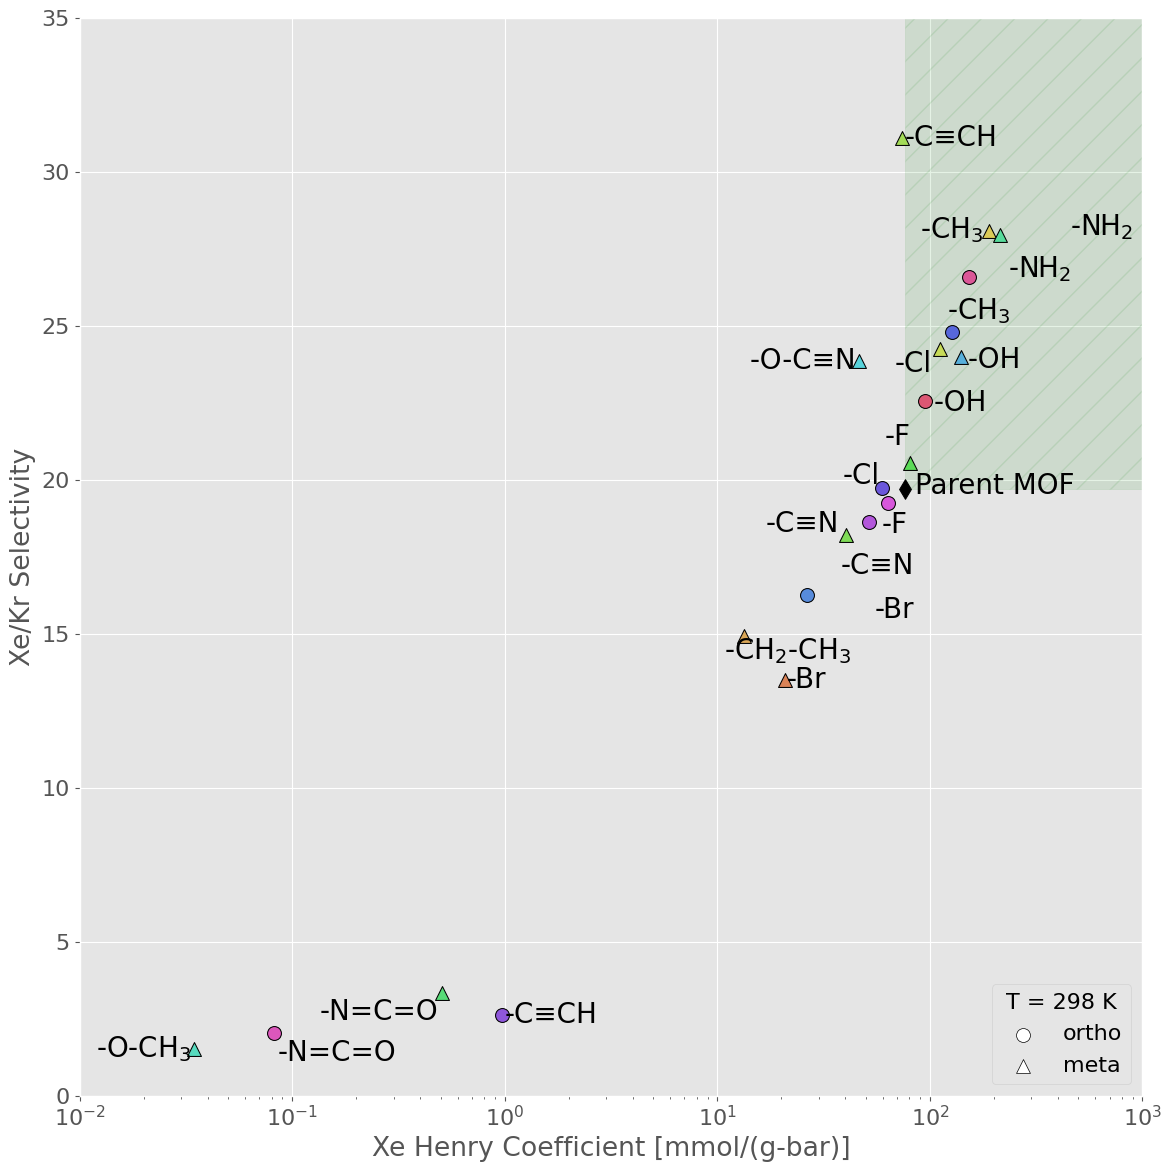

In [18]:
fig, axs = plt.subplots(figsize=(12, 12)) # figsize=(10, 10)

s1 = axs.scatter([], [], marker="o", s=100, label="ortho", color="w", edgecolor="k")
s2 = axs.scatter([], [], marker="^", s=100, label="meta", color="w", edgecolor="k")


# # error bars
# xe_err = henry_err_array(henry_results, "Xe")
# sel_err = [s_xekr[key]["err Xe/Kr"] for key in sorted_names]

for (i, key) in enumerate(sorted_names)
    axs.scatter(henry_coeff_array(henry_results, "Xe")[i],
                s_xekr[key]["Xe/Kr"],
                s=100,
                marker=arene_to_marker[i], 
                linewidths=0.75,
                edgecolors="k",
                color=xtal_to_color[key],
                zorder=2.5)
end

texts = [axs.text(henry_coeff_array(henry_results, "Xe")[i],
                    s_xekr[key]["Xe/Kr"], 
                    name_to_label[i],
                    fontsize=20,
                    zorder=2.5) 
                  for (i, key) in enumerate(sorted_names)]

# highlight upper right corner of plot
xmin = 0.01; xmax = 1000
ymin = 0.0;  ymax = 35

x_range = range(henry_results["Parent MOF"]["Xe"]["henry coefficient [mmol/(g-bar)]"], stop=xmax, length=25)
y_range = range(s_xekr["Parent MOF"]["Xe/Kr"], stop=ymax, length=25)
y_vals = [s_xekr["Parent MOF"]["Xe/Kr"] for n in y_range] 

axs.fill_between(x_range, y_vals, [ymax for n in 1:25], hatch="/", alpha=0.1, color="green")

# set axis 
axs.set_xscale("log")
axs.set_xlim(xmin, xmax)
axs.set_ylim(ymin, ymax)

# arrowprops = Dict(:arrowstyle => "->", :color => "k", :lw => 0.5)
adjustText.adjust_text(texts, 
                    expand_text=(1.05, 1.2),
                    expand_points=(1.05, 1.2),
                    expand_objects=(1.05, 1.2),
                    expand_align=(1.05, 1.2),
                    autoalign="x",
                    force_text=(0.1, 0.25),
                    force_points=(0.2, 0.5),
                    force_objects=(0.1, 0.25),
                    lim=2500,
                    precision=0.01,
                    avoid_text=true,
                    avoid_points=true,
                    avoid_self=true)



legend([s1, s2], ["ortho", "meta"], loc="lower right", title="T = 298 K")

axs.grid("on")
# axs.set_facecolor("C3")

# axs.set_title(L"H$_{Xe}$ vs S$_{Xe/Kr}$")
axs.set_xlabel("Xe Henry Coefficient [mmol/(g-bar)]")
axs.set_ylabel("Xe/Kr Selectivity")

tight_layout()
savefig("H_Xe_vs_Sel_XeKr.pdf", dpi=600, format="pdf")
# savefig("H_Xe_vs_Sel_XeKr.png", dpi=600, format="png")

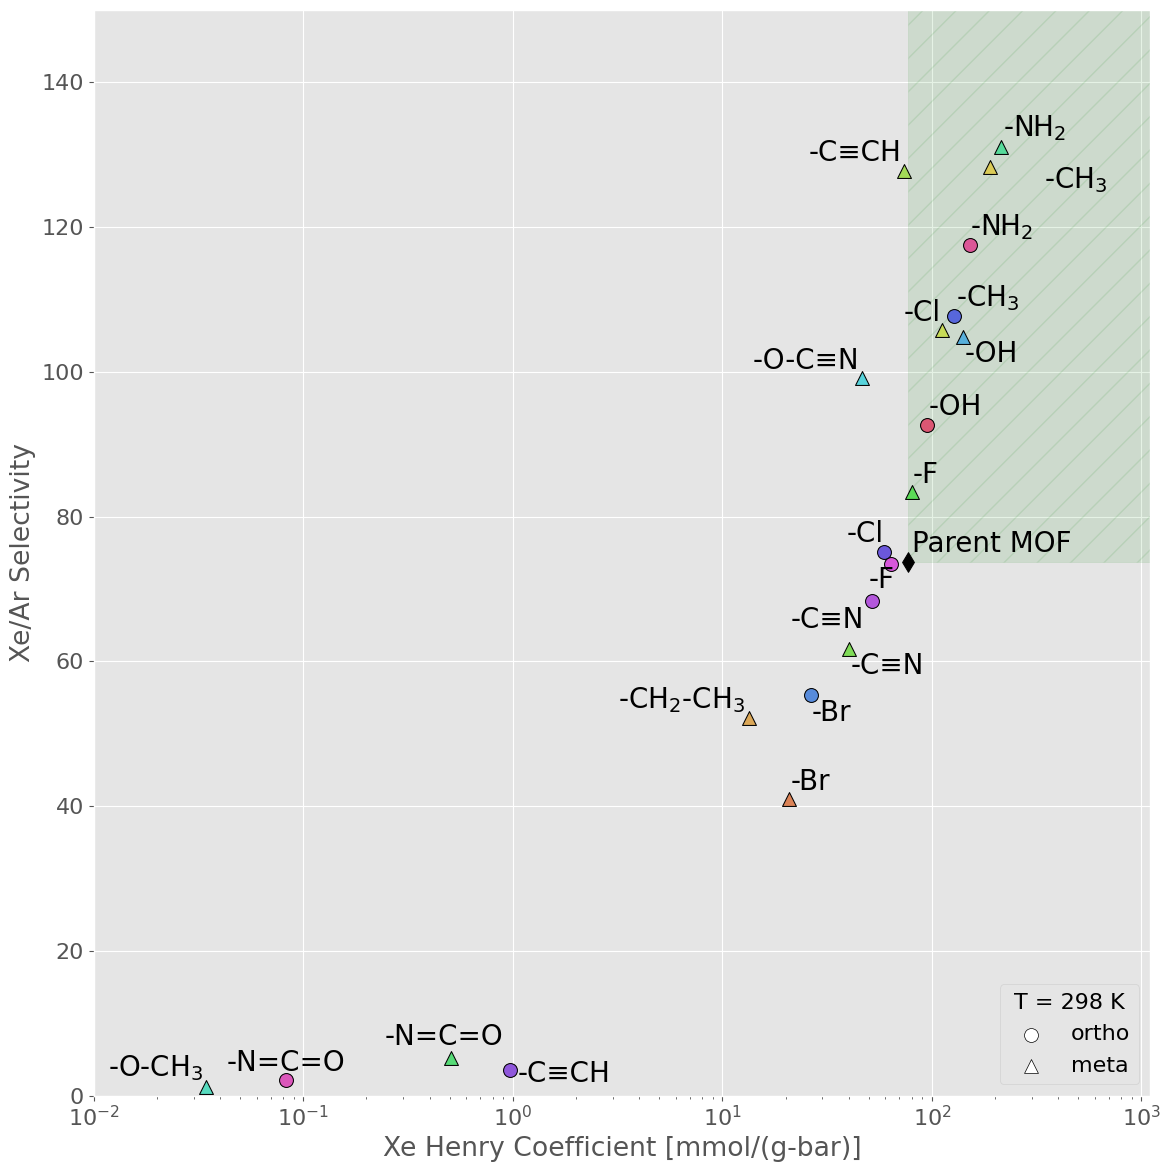

In [19]:
fig, axs = plt.subplots(figsize=(12, 12)) # figsize=(10, 10)

s1 = axs.scatter([], [], marker="o", s=100, label="ortho", color="w", edgecolor="k")
s2 = axs.scatter([], [], marker="^", s=100, label="meta", color="w", edgecolor="k")


# # error bars
# xe_err = henry_err_array(henry_results, "Xe")
# sel_err = [s_xekr[key]["err Xe/Kr"] for key in sorted_names]

for (i, key) in enumerate(sorted_names)
    axs.scatter(henry_coeff_array(henry_results, "Xe")[i],
                s_xear[key]["Xe/Ar"],
                s=100,
                marker=arene_to_marker[i], 
                linewidths=0.75,
                edgecolors="k",
                color=xtal_to_color[key],
                zorder=2.5)
end

texts = [axs.text(henry_coeff_array(henry_results, "Xe")[i],
                    s_xear[key]["Xe/Ar"], 
                    name_to_label[i],
                    fontsize=20,
                    zorder=2.5) 
                  for (i, key) in enumerate(sorted_names)]

# highlight upper right corner of plot
xmin = 0.01; xmax = 1100
ymin = 0.0;  ymax = 150

x_range = range(henry_results["Parent MOF"]["Xe"]["henry coefficient [mmol/(g-bar)]"], stop=xmax, length=25)
y_range = range(s_xear["Parent MOF"]["Xe/Ar"], stop=ymax, length=25)
y_vals = [s_xear["Parent MOF"]["Xe/Ar"] for n in y_range] 

axs.fill_between(x_range, y_vals, [ymax for n in 1:25], hatch="/", alpha=0.1, color="green")

# set axis 
axs.set_xscale("log")
axs.set_xlim(xmin, xmax)
axs.set_ylim(ymin, ymax)

# arrowprops = Dict(:arrowstyle => "->", :color => "k", :lw => 0.5)
adjustText.adjust_text(texts, 
                    expand_text=(1.05, 1.2),
                    expand_points=(1.05, 1.2),
                    expand_objects=(1.05, 1.2),
                    expand_align=(1.05, 1.2),
                    autoalign="xy",
                    force_text=(0.1, 0.25),
                    force_points=(0.2, 0.5),
                    force_objects=(0.1, 0.25),
                    lim=2500,
                    precision=0.01,
                    avoid_text=true,
                    avoid_points=true,
                    avoid_self=true)



legend([s1, s2], ["ortho", "meta"], loc="lower right", title="T = 298 K")

axs.grid("on")
# axs.set_facecolor("C3")

# axs.set_title(L"H$_{Xe}$ vs S$_{Xe/Kr}$")
axs.set_xlabel("Xe Henry Coefficient [mmol/(g-bar)]")
axs.set_ylabel("Xe/Ar Selectivity")

tight_layout()
savefig("H_Xe_vs_Sel_XeAr.pdf", dpi=600, format="pdf")

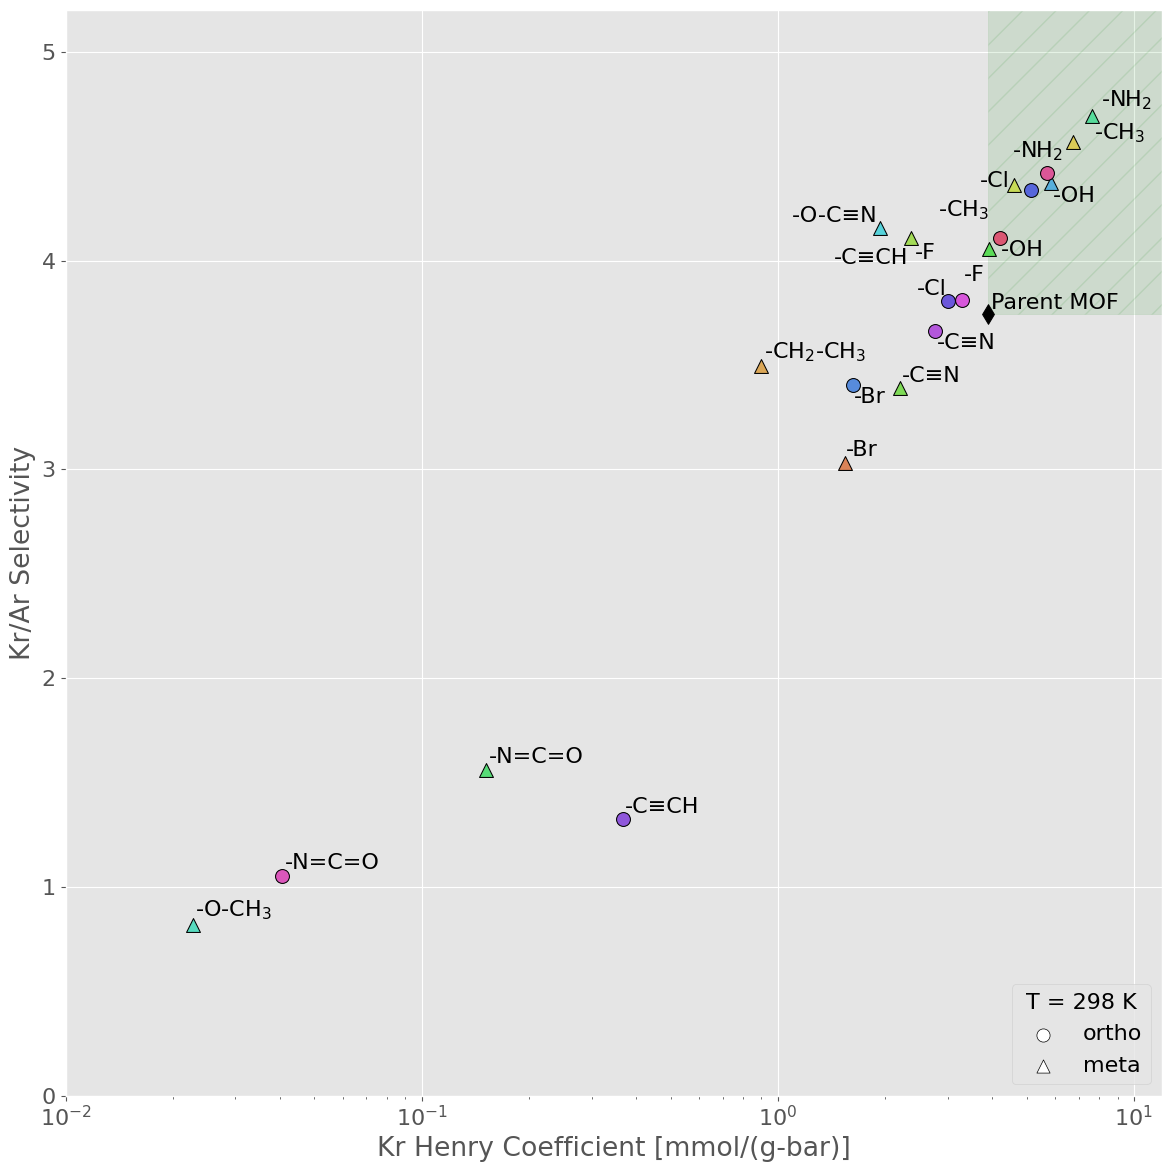

In [20]:
fig, axs = plt.subplots(figsize=(12, 12)) # figsize=(10, 10)

s1 = axs.scatter([], [], marker="o", s=90, label="ortho", color="w", edgecolor="k")
s2 = axs.scatter([], [], marker="^", s=90, label="meta", color="w", edgecolor="k")


# # error bars
# xe_err = henry_err_array(henry_results, "Xe")
# sel_err = [s_xekr[key]["err Xe/Kr"] for key in sorted_names]

for (i, key) in enumerate(sorted_names)
    axs.scatter(henry_coeff_array(henry_results, "Kr")[i],
                s_krar[key]["Kr/Ar"],
                s=100,
                marker=arene_to_marker[i], 
                linewidths=0.75,
                edgecolors="k",
                color=xtal_to_color[key],
                zorder=2.5)
end

texts = [axs.text(henry_coeff_array(henry_results, "Kr")[i],
                    s_krar[key]["Kr/Ar"], 
                    name_to_label[i],
                    fontsize=16,
                    zorder=2.5) 
                  for (i, key) in enumerate(sorted_names)]

# highlight upper right corner of plot
xmin = 0.01; xmax = 12
ymin = 0.0;  ymax = 5.2

x_range = range(henry_results["Parent MOF"]["Kr"]["henry coefficient [mmol/(g-bar)]"], stop=xmax, length=25)
y_range = range(s_krar["Parent MOF"]["Kr/Ar"], stop=ymax, length=25)
y_vals = [s_krar["Parent MOF"]["Kr/Ar"] for n in y_range] 

axs.fill_between(x_range, y_vals, [ymax for n in 1:25], hatch="/", alpha=0.1, color="green")

# set axis 
axs.set_xscale("log")
axs.set_xlim(xmin, xmax)
axs.set_ylim(ymin, ymax)

# arrowprops = Dict(:arrowstyle => "->", :color => "k", :lw => 0.5)
adjustText.adjust_text(texts, 
                    expand_text=(1.05, 1.2),
                    expand_points=(1.05, 1.2),
                    expand_objects=(1.05, 1.2),
                    expand_align=(1.05, 1.2),
                    autoalign="xy",
                    force_text=(0.1, 0.25),
                    force_points=(0.2, 0.5),
                    force_objects=(0.1, 0.25),
                    lim=2500,
                    precision=0.01,
                    avoid_text=true,
                    avoid_points=true,
                    avoid_self=true)



legend([s1, s2], ["ortho", "meta"], loc="lower right", title="T = 298 K")

axs.grid("on")
# axs.set_facecolor("C3")

# axs.set_title(L"H$_{Xe}$ vs S$_{Xe/Kr}$")
axs.set_xlabel("Kr Henry Coefficient [mmol/(g-bar)]")
axs.set_ylabel("Kr/Ar Selectivity")

tight_layout()
savefig("H_Kr_vs_Sel_KrAr.pdf", dpi=600, format="pdf")